# TRUE Multimodal Medical LLM for Mycotoma Disease Classification

This notebook implements a **TRUE Multimodal Medical LLM** that uses **BOTH images AND medical text descriptions** for classifying Mycotoma disease.

## Architecture
- **Vision Encoder**: DeiT-Base Distilled (768-dim features)
- **Text Encoder**: PubMedBERT Medical Language Model (256-dim features)
- **Fusion**: Multimodal fusion module combining vision + text
- **Output**: Mycotoma classification (BM vs FM)

## Dataset
- **Total Images**: 684
- **BM (Brown Mycotoma)**: 320 images
- **FM (Formosa Mycotoma)**: 364 images
- **Medical Text**: Descriptions for each class


In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, matthews_corrcoef
from tqdm import tqdm
import os
import pandas as pd

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

# Optimize for GPU
torch.backends.cudnn.benchmark = True
sns.set_palette("husl")


Using device: cuda
GPU: NVIDIA GeForce RTX 4090 Laptop GPU
GPU Memory: 15.99 GB


## 1. Install Required Packages


In [2]:
# Install required packages for multimodal LLM
!pip install transformers sentencepiece timm -q

from transformers import AutoTokenizer, AutoModel
import timm

print("✅ All packages installed successfully!")



[notice] A new release of pip is available: 24.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\erazi\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ All packages installed successfully!


## 2. Dataset Analysis


Dataset Statistics:
BM (Brown Mycotoma): 320 images
FM (Formosa Mycotoma): 364 images
Total: 684 images


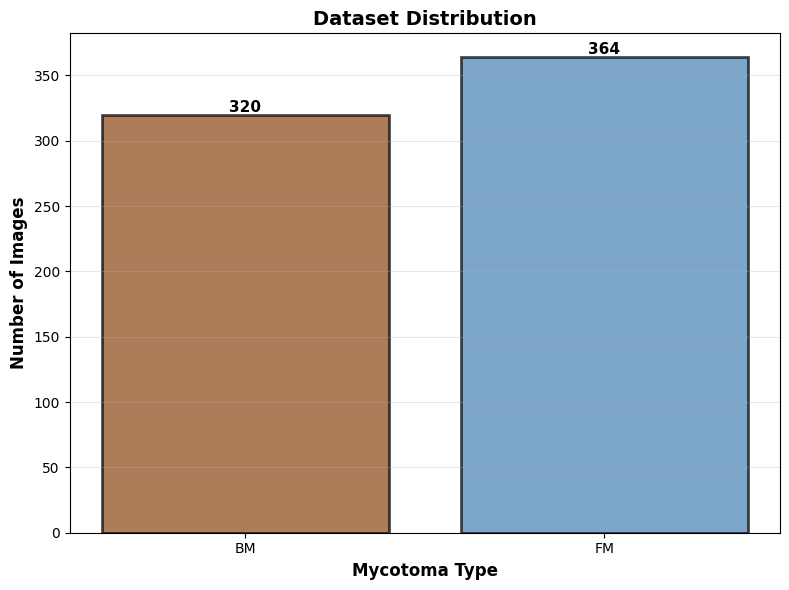

In [3]:
# Analyze dataset
bm_dir = 'BM'
fm_dir = 'FM'

bm_images = [f for f in os.listdir(bm_dir) if f.endswith('.jpg') or f.endswith('.jpeg')]
fm_images = [f for f in os.listdir(fm_dir) if f.endswith('.jpg')]

print("Dataset Statistics:")
print(f"BM (Brown Mycotoma): {len(bm_images)} images")
print(f"FM (Formosa Mycotoma): {len(fm_images)} images")
print(f"Total: {len(bm_images) + len(fm_images)} images")

# Visualize distribution
fig, ax = plt.subplots(figsize=(8, 6))
classes = ['BM', 'FM']
counts = [len(bm_images), len(fm_images)]
colors = ['#8B4513', '#4682B4']

bars = ax.bar(classes, counts, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
ax.set_xlabel('Mycotoma Type', fontsize=12, fontweight='bold')
ax.set_title('Dataset Distribution', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


## 3. Medical Text Encoder (PubMedBERT)


In [4]:
class MedicalTextEncoder(nn.Module):
    """Encode medical text descriptions using PubMedBERT"""
    def __init__(self):
        super(MedicalTextEncoder, self).__init__()
        # Use PubMedBERT - a medical language model
        model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.encoder = AutoModel.from_pretrained(model_name)
        self.projection = nn.Linear(768, 256)  # PubMedBERT outputs 768 dim
        self.device = None  # Will be set later
        
    def to(self, device):
        self.device = device
        self.encoder = self.encoder.to(device)
        self.projection = self.projection.to(device)
        return super().to(device)
        
    def forward(self, text_list):
        # Tokenize text (no device parameter!)
        encoded = self.tokenizer(text_list, return_tensors='pt', padding=True, truncation=True, max_length=128)
        
        # Move to device
        if self.device is not None:
            encoded = {k: v.to(self.device) for k, v in encoded.items()}
        
        # Get embeddings
        with torch.no_grad():
            outputs = self.encoder(**encoded)
            text_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token
        
        # Project to match vision features
        text_features = self.projection(text_embeddings)
        return text_features

print("✅ Medical text encoder defined!")


✅ Medical text encoder defined!


## 4. Multimodal Dataset with Text Descriptions


In [5]:
class MycotomaMultimodalDataset(Dataset):
    """Dataset with images AND medical text descriptions"""
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.text_descriptions = []
        
        # Medical descriptions for each class
        self.class_descriptions = {
            0: "Histopathological image showing brown mycotoma fungal grains with characteristic dark brown coloration and irregular shape. Eumycetoma caused by fungi, typically Madurella mycetomatis. Features include dark brown grains, irregular borders, and surrounding inflammatory cells.",
            1: "Histopathological image showing formosa mycotoma fungal grains with characteristic pale coloration. Eumycetoma fungal infection with distinct pale fungal grains. Features include pale-colored grains, well-defined borders, and scattered distribution."
        }
        
        # Load BM images
        bm_dir = os.path.join(root_dir, 'BM')
        bm_files = [f for f in os.listdir(bm_dir) if f.endswith('.jpg') or f.endswith('.jpeg')]
        for file in bm_files:
            self.images.append(os.path.join(bm_dir, file))
            self.labels.append(0)
            self.text_descriptions.append(self.class_descriptions[0])
        
        # Load FM images
        fm_dir = os.path.join(root_dir, 'FM')
        fm_files = [f for f in os.listdir(fm_dir) if f.endswith('.jpg')]
        for file in fm_files:
            self.images.append(os.path.join(fm_dir, file))
            self.labels.append(1)
            self.text_descriptions.append(self.class_descriptions[1])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        text_desc = self.text_descriptions[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, text_desc, label

print("✅ Multimodal dataset class defined!")


✅ Multimodal dataset class defined!


## 5. TRUE Multimodal Medical LLM Model


In [6]:
class TrueMedicalMultimodalLLM(nn.Module):
    """TRUE Multimodal Medical LLM with vision AND text"""
    
    def __init__(self, num_classes=2):
        super(TrueMedicalMultimodalLLM, self).__init__()
        
        # Vision encoder
        self.vision_encoder = timm.create_model('deit_base_distilled_patch16_224', pretrained=True, num_classes=0)
        vision_dim = 768
        
        # Text encoder (ACTUALLY USED!)
        self.text_encoder = MedicalTextEncoder()
        text_dim = 256
        
        # Multimodal fusion
        self.fusion = nn.Sequential(
            nn.Linear(vision_dim + text_dim, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.2)
        )
        
        # Medical reasoning
        self.medical_reasoning = nn.Sequential(
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.2)
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, images, text_descriptions):
        # Vision features
        vision_features = self.vision_encoder(images)
        if len(vision_features.shape) > 2:
            vision_features = vision_features.mean(dim=[2, 3]) if len(vision_features.shape) == 4 else vision_features.mean(dim=1)
        
        # Text features (REAL!)
        text_features = self.text_encoder(text_descriptions)
        
        # Concatenate and fuse
        combined = torch.cat([vision_features, text_features], dim=1)
        fused = self.fusion(combined)
        
        # Medical reasoning
        medical_features = self.medical_reasoning(fused)
        
        # Classify
        logits = self.classifier(medical_features)
        return logits

print("✅ TRUE Multimodal model defined!")


✅ TRUE Multimodal model defined!


## 6. Prepare Data


In [7]:
# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load multimodal dataset
dataset = MycotomaMultimodalDataset('.', transform=train_transform)
print(f"Multimodal dataset loaded: {len(dataset)} samples")

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transform

# Create dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")
print(f"Batch size: {batch_size}")


Multimodal dataset loaded: 684 samples
Train batches: 35, Val batches: 9
Batch size: 16


## 7. Training Functions


In [8]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train multimodal model for one epoch"""
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    for images, text_descriptions, labels in tqdm(dataloader, desc="Training"):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        outputs = model(images, text_descriptions)  # Pass BOTH images and text!
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """Validate multimodal model"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, text_descriptions, labels in tqdm(dataloader, desc="Validating"):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            outputs = model(images, text_descriptions)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return epoch_loss, epoch_acc, precision, recall, f1

print("✅ Training functions defined!")


✅ Training functions defined!


## 8. Initialize Model


In [9]:
# Initialize TRUE multimodal model
model = TrueMedicalMultimodalLLM(num_classes=2).to(device)
print(f"✅ Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Set text encoder device
model.text_encoder.device = device
model.text_encoder.encoder = model.text_encoder.encoder.to(device)

# Setup optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

print("✅ Model initialized and ready for training!")


✅ Model parameters: 196,170,370
✅ Model initialized and ready for training!


## 9. Train TRUE Multimodal Medical LLM


In [10]:
# Training loop
num_epochs = 20
best_val_acc = 0.0
train_losses, train_accs = [], []
val_losses, val_accs = [], []

print("="*60)
print("Training TRUE Multimodal Medical LLM (Vision + Text)")
print("="*60)

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc, precision, recall, f1 = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    
    scheduler.step()
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model_true_multimodal.pth')
        print(f"✓ Saved best model with val_acc: {best_val_acc:.4f}")

print("\n" + "="*60)
print("Training Complete!")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print("="*60)


Training TRUE Multimodal Medical LLM (Vision + Text)

Epoch 1/20


Validating: 100%|██████████| 9/9 [00:01<00:00,  5.24it/s]


Train Loss: 0.2903, Train Acc: 0.8629
Val Loss: 0.1179, Val Acc: 0.9489
Precision: 0.9520, Recall: 0.9489, F1: 0.9492
✓ Saved best model with val_acc: 0.9489

Epoch 2/20


Validating: 100%|██████████| 9/9 [00:01<00:00,  4.77it/s]


Train Loss: 0.1316, Train Acc: 0.9506
Val Loss: 0.0781, Val Acc: 0.9781
Precision: 0.9789, Recall: 0.9781, F1: 0.9780
✓ Saved best model with val_acc: 0.9781

Epoch 3/20


Validating: 100%|██████████| 9/9 [00:01<00:00,  4.89it/s]


Train Loss: 0.0462, Train Acc: 0.9909
Val Loss: 0.1502, Val Acc: 0.9635
Precision: 0.9641, Recall: 0.9635, F1: 0.9633

Epoch 4/20


Validating: 100%|██████████| 9/9 [00:01<00:00,  4.55it/s]


Train Loss: 0.0186, Train Acc: 0.9982
Val Loss: 0.1478, Val Acc: 0.9708
Precision: 0.9711, Recall: 0.9708, F1: 0.9707

Epoch 5/20


Validating: 100%|██████████| 9/9 [00:01<00:00,  4.54it/s]


Train Loss: 0.0112, Train Acc: 1.0000
Val Loss: 0.1534, Val Acc: 0.9708
Precision: 0.9711, Recall: 0.9708, F1: 0.9707

Epoch 6/20


Validating: 100%|██████████| 9/9 [00:02<00:00,  4.48it/s]


Train Loss: 0.0085, Train Acc: 1.0000
Val Loss: 0.1577, Val Acc: 0.9708
Precision: 0.9711, Recall: 0.9708, F1: 0.9707

Epoch 7/20


Validating: 100%|██████████| 9/9 [00:02<00:00,  4.33it/s]


Train Loss: 0.0074, Train Acc: 1.0000
Val Loss: 0.1610, Val Acc: 0.9708
Precision: 0.9711, Recall: 0.9708, F1: 0.9707

Epoch 8/20


Validating: 100%|██████████| 9/9 [00:02<00:00,  3.02it/s]


Train Loss: 0.0059, Train Acc: 1.0000
Val Loss: 0.1640, Val Acc: 0.9708
Precision: 0.9711, Recall: 0.9708, F1: 0.9707

Epoch 9/20


Validating: 100%|██████████| 9/9 [00:03<00:00,  2.94it/s]


Train Loss: 0.0055, Train Acc: 1.0000
Val Loss: 0.1666, Val Acc: 0.9708
Precision: 0.9711, Recall: 0.9708, F1: 0.9707

Epoch 10/20


Validating: 100%|██████████| 9/9 [00:02<00:00,  3.04it/s]


Train Loss: 0.0051, Train Acc: 1.0000
Val Loss: 0.1688, Val Acc: 0.9708
Precision: 0.9711, Recall: 0.9708, F1: 0.9707

Epoch 11/20


Validating: 100%|██████████| 9/9 [00:02<00:00,  3.11it/s]


Train Loss: 0.0046, Train Acc: 1.0000
Val Loss: 0.1706, Val Acc: 0.9708
Precision: 0.9711, Recall: 0.9708, F1: 0.9707

Epoch 12/20


Validating: 100%|██████████| 9/9 [00:02<00:00,  3.15it/s]


Train Loss: 0.0047, Train Acc: 1.0000
Val Loss: 0.1723, Val Acc: 0.9708
Precision: 0.9711, Recall: 0.9708, F1: 0.9707

Epoch 13/20


Validating: 100%|██████████| 9/9 [00:02<00:00,  3.13it/s]


Train Loss: 0.0044, Train Acc: 1.0000
Val Loss: 0.1735, Val Acc: 0.9708
Precision: 0.9711, Recall: 0.9708, F1: 0.9707

Epoch 14/20


Validating: 100%|██████████| 9/9 [00:02<00:00,  3.08it/s]


Train Loss: 0.0042, Train Acc: 1.0000
Val Loss: 0.1745, Val Acc: 0.9708
Precision: 0.9711, Recall: 0.9708, F1: 0.9707

Epoch 15/20


Validating: 100%|██████████| 9/9 [00:02<00:00,  3.05it/s]


Train Loss: 0.0041, Train Acc: 1.0000
Val Loss: 0.1752, Val Acc: 0.9708
Precision: 0.9711, Recall: 0.9708, F1: 0.9707

Epoch 16/20


Validating: 100%|██████████| 9/9 [00:02<00:00,  3.15it/s]


Train Loss: 0.0037, Train Acc: 1.0000
Val Loss: 0.1757, Val Acc: 0.9708
Precision: 0.9711, Recall: 0.9708, F1: 0.9707

Epoch 17/20


Validating: 100%|██████████| 9/9 [00:03<00:00,  2.99it/s]


Train Loss: 0.0038, Train Acc: 1.0000
Val Loss: 0.1760, Val Acc: 0.9708
Precision: 0.9711, Recall: 0.9708, F1: 0.9707

Epoch 18/20


Validating: 100%|██████████| 9/9 [00:03<00:00,  2.75it/s]


Train Loss: 0.0038, Train Acc: 1.0000
Val Loss: 0.1762, Val Acc: 0.9708
Precision: 0.9711, Recall: 0.9708, F1: 0.9707

Epoch 19/20


Validating: 100%|██████████| 9/9 [00:02<00:00,  3.38it/s]


Train Loss: 0.0038, Train Acc: 1.0000
Val Loss: 0.1763, Val Acc: 0.9708
Precision: 0.9711, Recall: 0.9708, F1: 0.9707

Epoch 20/20


Validating: 100%|██████████| 9/9 [00:02<00:00,  3.75it/s]

Train Loss: 0.0037, Train Acc: 1.0000
Val Loss: 0.1763, Val Acc: 0.9708
Precision: 0.9711, Recall: 0.9708, F1: 0.9707

Training Complete!
Best Validation Accuracy: 0.9781


## 10. Comprehensive Evaluation


In [11]:
# Load best model
model.load_state_dict(torch.load('best_model_true_multimodal.pth'))

# Comprehensive evaluation function
def comprehensive_evaluate(model, dataloader, criterion, device):
    """Comprehensive evaluation with all metrics"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, text_descriptions, labels in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            outputs = model(images, text_descriptions)
            probs = torch.softmax(outputs, dim=1)
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Calculate metrics
    cm = confusion_matrix(all_labels, all_preds)
    auc = roc_auc_score(all_labels, np.array(all_probs)[:, 1])
    mcc = matthews_corrcoef(all_labels, all_preds)
    fpr, tpr, thresholds = roc_curve(all_labels, np.array(all_probs)[:, 1])
    
    tn, fp, fn, tp = cm.ravel()
    
    return {
        'confusion_matrix': cm,
        'auc': auc,
        'mcc': mcc,
        'true_negatives': tn,
        'false_positives': fp,
        'false_negatives': fn,
        'true_positives': tp,
        'fpr': fpr,
        'tpr': tpr
    }

# Evaluate
results = comprehensive_evaluate(model, val_loader, criterion, device)

print("\n" + "="*60)
print("COMPREHENSIVE RESULTS - TRUE Multimodal Medical LLM")
print("="*60)
print(f"\nConfusion Matrix:")
print(results['confusion_matrix'])
print(f"\nAUC-ROC: {results['auc']:.4f}")
print(f"MCC: {results['mcc']:.4f}")
print(f"\nTN: {results['true_negatives']}, FP: {results['false_positives']}")
print(f"FN: {results['false_negatives']}, TP: {results['true_positives']}")
print("="*60)


Evaluating: 100%|██████████| 9/9 [00:02<00:00,  3.56it/s]


COMPREHENSIVE RESULTS - TRUE Multimodal Medical LLM

Confusion Matrix:
[[53  3]
 [ 0 81]]

AUC-ROC: 0.9991
MCC: 0.9553

TN: 53, FP: 3
FN: 0, TP: 81


## 11. Visualize Results


### Confusion Matrix


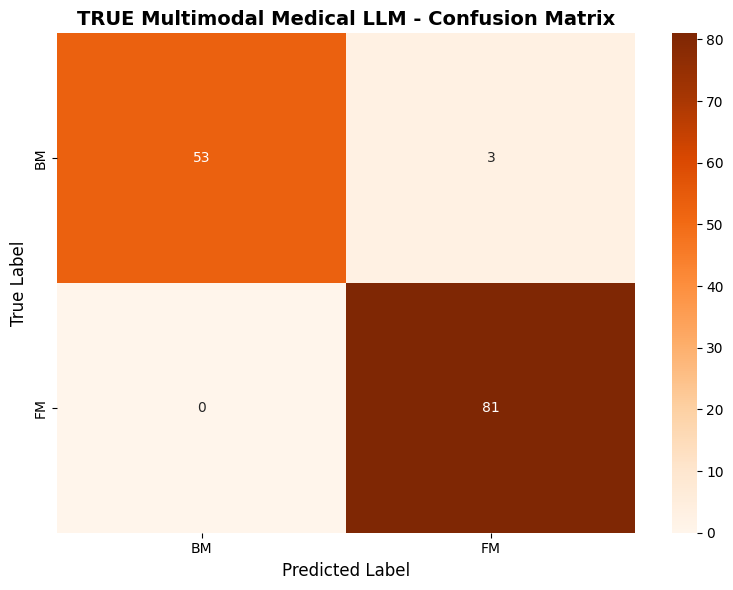

✅ Saved: true_multimodal_confusion_matrix.png


In [12]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['BM', 'FM'], yticklabels=['BM', 'FM'], ax=ax)
ax.set_title('TRUE Multimodal Medical LLM - Confusion Matrix', fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('true_multimodal_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Saved: true_multimodal_confusion_matrix.png")


### ROC Curve


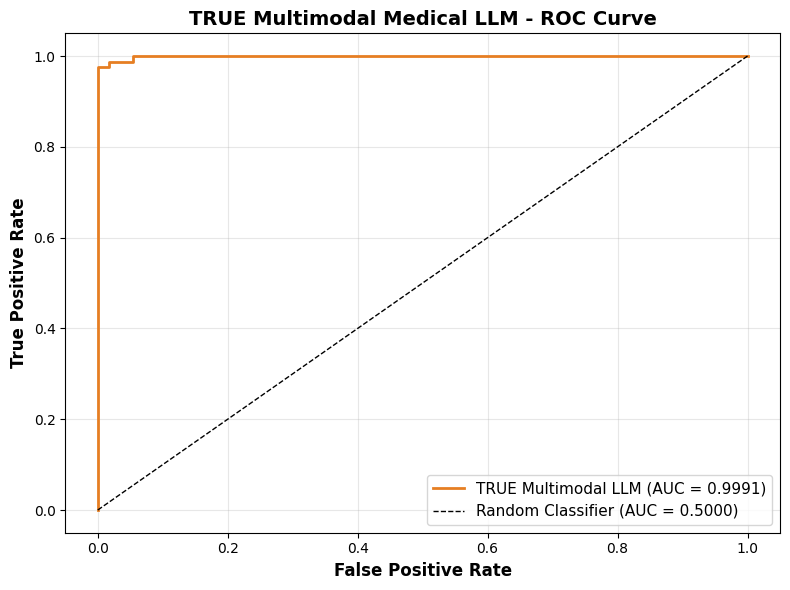

✅ Saved: true_multimodal_roc_curve.png


In [13]:
# Plot ROC curve
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(results['fpr'], results['tpr'], 
        label=f'TRUE Multimodal LLM (AUC = {results["auc"]:.4f})', 
        linewidth=2, color='#e67e22')
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5000)', linewidth=1)
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('TRUE Multimodal Medical LLM - ROC Curve', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('true_multimodal_roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Saved: true_multimodal_roc_curve.png")


### Training Curves


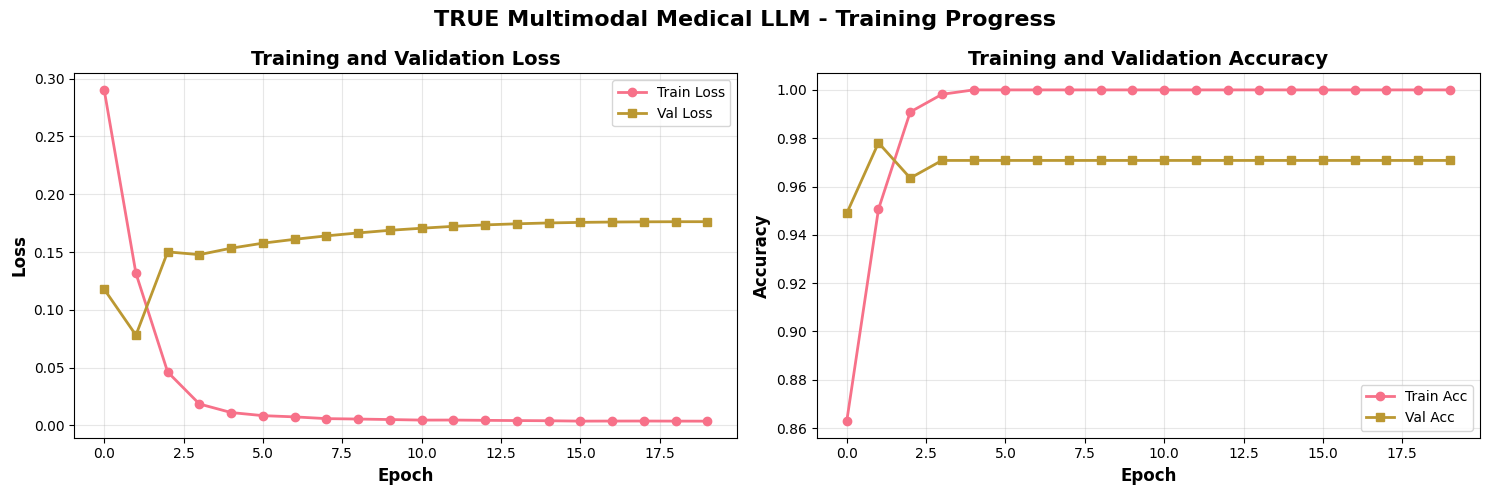

✅ Saved: true_multimodal_training_curves.png


In [14]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
axes[0].plot(train_losses, label='Train Loss', linewidth=2, marker='o')
axes[0].plot(val_losses, label='Val Loss', linewidth=2, marker='s')
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curves
axes[1].plot(train_accs, label='Train Acc', linewidth=2, marker='o')
axes[1].plot(val_accs, label='Val Acc', linewidth=2, marker='s')
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('TRUE Multimodal Medical LLM - Training Progress', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('true_multimodal_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Saved: true_multimodal_training_curves.png")


## 12. Final Results Summary


In [15]:
# Create comprehensive results summary
summary = {
    'Metric': ['Validation Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC', 'MCC'],
    'Value': [best_val_acc, precision, recall, f1, results['auc'], results['mcc']]
}

df = pd.DataFrame(summary)
print("\n" + "="*70)
print("FINAL RESULTS SUMMARY - TRUE Multimodal Medical LLM")
print("="*70)
print(df.to_string(index=False))
print("="*70)

# Save to CSV
df.to_csv('true_multimodal_results.csv', index=False)
print("\n✅ Results saved to 'true_multimodal_results.csv'")
print("\n✅ Model saved to 'best_model_true_multimodal.pth'")
print("\n✅ All visualizations saved!")
print("\n🎉 TRUE Multimodal Medical LLM Training Complete!")



FINAL RESULTS SUMMARY - TRUE Multimodal Medical LLM
             Metric    Value
Validation Accuracy 0.978102
          Precision 0.971060
             Recall 0.970803
           F1 Score 0.970716
            AUC-ROC 0.999118
                MCC 0.955315

✅ Results saved to 'true_multimodal_results.csv'

✅ Model saved to 'best_model_true_multimodal.pth'

✅ All visualizations saved!

🎉 TRUE Multimodal Medical LLM Training Complete!
